In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score

from itertools import product

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from scipy.stats import mode

I pulled and cleaned a comprehensive dataset of colleges from this governmental database:
    
https://collegescorecard.ed.gov/data/

Let's read this dataset in:

In [2]:
df = pd.read_csv('data/schools.csv', index_col = 0)
print(df.shape)
df.head()

(6740, 46)


,name,ownership,ope6_id,state,size,accreditor,retention,branches,online_only,religious_affil,...,fafsa_sent,7_yr_repayment_completion,5_year_declining_balance,relig_y_n,accred_y_n,retention_listed_y_n,fac_salary_listed_y_n,7_yr_repayment_completion_y_n,5_year_declining_balance_y_n,for_profit
0,Alaska Bible College,2,8843,AK,27,Association for Bibical Higher Educaiton,0.333300,1,0,88.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
1,Alaska Christian College,2,41386,AK,68,Association for Bibical Higher Educaiton,0.473700,1,0,37.0,...,0.463652,0.699542,0.496850,1,1,1,1,0,0,0
2,Ilisagvik College,1,34613,AK,109,Northwest Commission on Colleges and Universities,0.809500,1,0,-2.0,...,0.463652,0.699542,0.496850,0,1,1,1,0,0,0
3,Charter College-Anchorage,3,25769,AK,3256,Accrediting Council for Independent Colleges a...,0.703723,1,0,-2.0,...,0.310288,0.725806,0.417949,0,1,0,1,1,1,1
4,Alaska Career College,3,25410,AK,479,Accrediting Commission of Career Schools and C...,0.794100,1,0,-2.0,...,0.254237,0.556430,0.462520,0,1,1,1,1,1,1


We are going to use classification algorithms to try to predict for-profit or non-profit status. 

Some of the categories aren't applicable to what we want to do so let's consider the following columns only:


In [3]:
X = df[['size','retention','branches', 'online_only', 'under_investigation', 'most_common_degree', 'highest_degree',
       'faculty_salary', 'instructional_expenditure_per_fte',
       'tuition_revenue_per_fte', 'part_time_share',
       'age_entry', 'percent_dependent', 'first_generation', 'percent_black',
        'avg_family_income','ind_low_income', 'dep_low_income', 'loan_principal',
       'federal_loan_rate', 'students_with_any_loans',
       'pell_grant_debt', 'percent_pell_grant',
       'fafsa_sent', '7_yr_repayment_completion', '5_year_declining_balance',
       'relig_y_n', 'accred_y_n', 'retention_listed_y_n',
       'fac_salary_listed_y_n', '7_yr_repayment_completion_y_n',
       '5_year_declining_balance_y_n', 'for_profit']]

Let's first use a method called [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) to see which features have the most statistically significant relationships with profit status. The **lower** the p value, the **more** statistically significant:

In [4]:
y = X.pop('for_profit')

X_new = SelectKBest(chi2, k=2).fit(X, y)

features = []
for i, column in enumerate(X.columns):
    features.append((X_new.pvalues_[i], column))
features.sort()
print('chi2-value', 'feature')
features

chi2-value feature


[(0.0, 'avg_family_income'),
 (0.0, 'branches'),
 (0.0, 'faculty_salary'),
 (0.0, 'instructional_expenditure_per_fte'),
 (0.0, 'loan_principal'),
 (0.0, 'pell_grant_debt'),
 (0.0, 'size'),
 (0.0, 'tuition_revenue_per_fte'),
 (5.339096890496358e-283, 'highest_degree'),
 (2.3550018048916394e-222, 'most_common_degree'),
 (5.4025502611485345e-149, 'fac_salary_listed_y_n'),
 (8.240679129762035e-148, 'relig_y_n'),
 (5.293172158552389e-143, 'age_entry'),
 (1.4125160311604572e-48, 'percent_dependent'),
 (1.429381130658807e-24, '5_year_declining_balance'),
 (1.3527931483014932e-21, 'federal_loan_rate'),
 (6.095800240149601e-17, 'percent_black'),
 (3.249757484508949e-15, 'fafsa_sent'),
 (2.3099399670292976e-10, '7_yr_repayment_completion'),
 (5.332261659651546e-09, 'first_generation'),
 (1.4079344574521532e-08, 'part_time_share'),
 (1.51637032044754e-08, 'dep_low_income'),
 (5.389960032435694e-08, 'percent_pell_grant'),
 (2.9423628117769607e-06, 'students_with_any_loans'),
 (9.035892891499908e-0

1.Based on the info above, what was intuitive? What was surprising? How big (or small) of an effect does accredition have on for-profit status? What might be some guesses as to why this is the case?

It was very surprising to me to see that the lisiting of faculty salary was closely related to for-profit status, as this is a very random fact that I did not believe would hold much weight with the status. I was also surprised that percent of students who were dependent had a very statistically significant relationship with for-profit status. The perfect chi-squared values of several variables concern me, as it is incredibly unlikely that all these variables could be perfectly correlated with for-profit status. However, it was not shocking that these variables had a close relationship with for-profit status, as for-profit colleges may have a lower instructional expenditure than non-profit colleges and for-profit colleges may have more students in the hopes of gaining more money from tuition.

Accredition, having a chi-squared value of around 0.825, has a very small effect on for-profit status, perhaps because most colleges in the United States are accredited and so have all have the same value (1) in this column. On the other hand, maybe non-accredited colleges are equally for-profit and non-profit, so being accredited doesn't add any significant insight into a college's status.

2.Do a test/train split and give the testing accuracy error for logistic regression.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter = 10000)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9055390702274976


3.Find the optimal number of nearest neighbors for KNN using grid search and then give the test accuracy. 

In [6]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
param_grid = {'n_neighbors': range(1, 20)}
model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
model = model.fit(X_train, y_train)
print(model.best_params_, model.best_estimator_)
model = model.best_estimator_
print(model.score(X_test, y_test))

{'n_neighbors': 5} KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
0.9347181008902077


4.Run a classification report and describe in detail what the terms mean in the context of your model.

In [7]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1149
           1       0.91      0.94      0.93       873

    accuracy                           0.93      2022
   macro avg       0.93      0.93      0.93      2022
weighted avg       0.94      0.93      0.93      2022



0.95 precision in the row of 0 means that out of all of the colleges that were classified as non-profits, 95% were actually non-profits, whereas 0.91 in the row of 1 means that out of all of the colleges classified as for-profit, only 91% were actually for profit.

0.93 recall in the 0th row means that the model found 93% of all the non-profit colleges in the test set, while 0.94 in the 1st row means that the model found 94% of all non-profit colleges.

A 0.94 F1-score with a 0 means that the harmonic mean of precision and recall for non-profit colleges was 0.94, while for for-profit colleges it was 0.93.

0.93 accuracy means that the model correctly classified 93% of colleges, while the macro average and weighted average do not matter, as the model has not been applied to multiple data sets.

A support of 1149 in the 0th row means that 1,149 of the colleges in the dataset were classified as non-profits, while a support of 873 in the 1st row means that 873 of the colleges were classified as for-profit. The supports in the last rows, 2022, represent the total number of colleges in the data set.

5.Print a confusion matrix and describe what it means in your context.

In [8]:
confusion_matrix(y_test, model.predict(X_test))

array([[1073,   76],
       [  56,  817]])

1073 non-profit colleges were correctly classified as non-profits by the model, while 56 were incorrectly classified as for-profit. 817 for-profit colleges were correctly classified and 76 were incorrectly classified.

6.Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, and KNN classifiers.

In [9]:
models = [naive_bayes.GaussianNB(),LogisticRegression(multi_class = "auto", solver = 'lbfgs', max_iter=10000), KNeighborsClassifier(n_neighbors=5), GradientBoostingClassifier()]
probs = []
for i in range(len(models)):
    model = models[i]
    model.fit(X_train, y_train)
    probs.append(model.predict_proba(X_test)[:, 1])

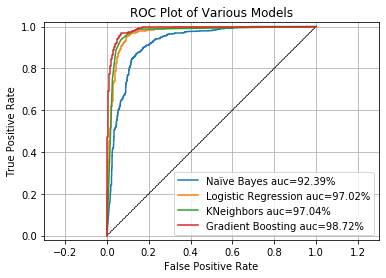

In [10]:
def plot_roc(ytrue, yproba, model, title='ROC Plot of Various Models'):
    auc = roc_auc_score(ytrue, yproba)
    fpr, tpr, thr = roc_curve(ytrue, yproba)
    plt.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=.4)
    plt.plot(fpr, tpr, label='{} auc={:.2f}%'.format(model, auc*100))
    plt.axis('equal')
    plt.xlim([-.02, 1.02])
    plt.ylim([-.02, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True) 
plot_roc(y_test, probs[0], "Naïve Bayes")
plot_roc(y_test, probs[1], "Logistic Regression")
plot_roc(y_test, probs[2], "KNeighbors")
plot_roc(y_test, probs[3], "Gradient Boosting")

7.Using the logistic regression model, plot a decision boundary between instructional_expenditure_per_fte and 5_year_declining_balance. Does it appear that for-profit status has a clear boundary based on these predictors?

(-2.941558886777559, 3.1784411132224464)

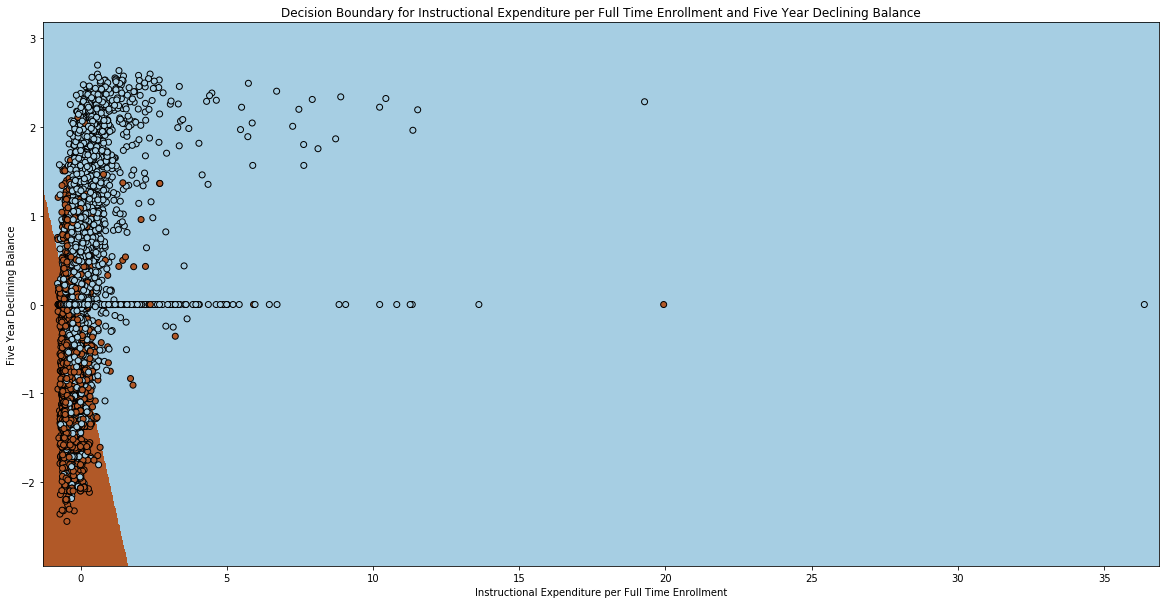

In [11]:
X = X.rename(columns = {'5_year_declining_balance': 'F_year_declining_balance'})
Xplot = X[['instructional_expenditure_per_fte', 'F_year_declining_balance']]
X_scaler = StandardScaler()
Xplot = X_scaler.fit_transform(Xplot)
Xplot = pd.DataFrame(Xplot)
Q = Xplot.values
h = .02
x_min, x_max = Q[:, 0].min() - .5, Q[:, 0].max() + .5
y_min, y_max = Q[:, 1].min() - .5, Q[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
model = LogisticRegression(solver = 'lbfgs')
model.fit(Xplot.iloc[:,:2], y)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(20, 10))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(Q[:, 0], Q[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
plt.title('Decision Boundary for Instructional Expenditure per Full Time Enrollment and Five Year Declining Balance')
plt.xlabel('Instructional Expenditure per Full Time Enrollment')
plt.ylabel('Five Year Declining Balance')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [12]:
#While not extremely strong, there is a mostly clear boundary between for-profit and non-profit colleges, 
#with for-profit colleges having very low instructional expenditure per full-time enrollment and mostly a
#very low five-year declining balance.

8.We have not covered random forests but they are a very popular type of classifier. It is very good practice in reading the docs to get a new classifier working. Read [this](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and then apply the RandomForestClassifier().

In [11]:
scorelist = []
for i in range(1, 101):
    model = RandomForestClassifier(n_estimators = i)
    model.fit(X_train,y_train)
    scorelist.append(model.score(X_test,y_test))
n = scorelist.index(max(scorelist))+1
model = RandomForestClassifier(n_estimators = n)
model.fit(X_train,y_train)
print(model.n_features_)
print(model.score(X_test,y_test))
print(classification_report(y_test, model.predict(X_test)))

32
0.9406528189910979
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1149
           1       0.93      0.93      0.93       873

    accuracy                           0.94      2022
   macro avg       0.94      0.94      0.94      2022
weighted avg       0.94      0.94      0.94      2022



9.Support vector machines are another type of classifier. Read the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and then try implementing that one.

In [12]:
kernellist = ['linear', 'poly', 'rbf', 'sigmoid']
for i in range(len(kernellist)):
    model = SVC(kernel = kernellist[i])
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
rbf is the best kernel
model = SVC(gamma = 'auto', kernel = 'rbf', probability = True)
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1149
           1       0.91      0.96      0.93       873

    accuracy                           0.94      2022
   macro avg       0.94      0.94      0.94      2022
weighted avg       0.94      0.94      0.94      2022



10. Make a comparative ROC plot of the naive bayes, logistic, gradient boosting, KNN classifiers, random forest, and SVM classifiers.

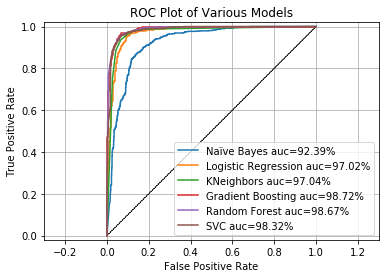

In [13]:
models = [RandomForestClassifier(n_estimators = n), SVC(gamma ='auto', kernel = 'rbf', probability = True)]
for i in range(len(models)):
    model = models[i]
    model.fit(X_train,y_train)
    probs.append(model.predict_proba(X_test)[:, 1])
plot_roc(y_test, probs[0], "Naïve Bayes")
plot_roc(y_test, probs[1], "Logistic Regression")
plot_roc(y_test, probs[2], "KNeighbors")
plot_roc(y_test, probs[3], "Gradient Boosting")
plot_roc(y_test, probs[4], "Random Forest")
plot_roc(y_test, probs[5], "SVC")

11.Take in a new school's data and predict the school's profit status using one of your previous classifier methods.

In [19]:
model = RandomForestClassifier(n_estimators = n)
model.fit(X_train, y_train)
print(model.predict([X_test[0]]))
print(X_test[0])
print(X.columns)

[1]
[ 4.28046548e-03  3.16431665e-03  1.12138004e+00 -7.86427846e-02
 -9.24697933e-02 -1.80115057e+00 -1.71830233e+00  5.55646466e-03
  1.34262148e-03  5.57986896e-03 -7.29184143e-03  5.81018441e-01
 -8.34259968e-01  1.22389777e+00  5.12172216e-03 -8.31195610e-01
  1.28521149e+00  8.34829892e-01  3.16514449e-01 -1.13835729e-02
  5.53178546e-01  7.10782538e-02  1.14780987e+00 -1.03352709e+00
 -1.24922575e-01 -7.75737179e-01 -3.86070163e-01  1.12532936e-01
 -2.06818880e+00 -1.27551902e+00  8.09950403e-01  5.31426100e-01]
Index(['size', 'retention', 'branches', 'online_only', 'under_investigation',
       'most_common_degree', 'highest_degree', 'faculty_salary',
       'instructional_expenditure_per_fte', 'tuition_revenue_per_fte',
       'part_time_share', 'age_entry', 'percent_dependent', 'first_generation',
       'percent_black', 'avg_family_income', 'ind_low_income',
       'dep_low_income', 'loan_principal', 'federal_loan_rate',
       'students_with_any_loans', 'pell_grant_debt', '

12.What are the worst schools? Some of them are chains of schools so don't necessarily consider singular names but generalize to chains. Give a lot of justification for your analysis as everyone might have a different answer here. Insert these responses into your blog.

In [5]:
X = X.join(y)
bad = X.loc[X['accred_y_n'] == 0]
#The first characteristic I decided to divide by is accredition. If a college is not accredited, 
#then it is highly unlikely its graduates will be able to get jobs, defeating the whole purpose of a college
#education. This criterion narrowed down the list of colleges to 88, which is was also much easier to work with.

In [6]:
bad = bad.drop(columns = ['size', 'retention', 'branches', 'online_only', 'under_investigation','most_common_degree', 'highest_degree', 'faculty_salary','part_time_share', 'age_entry', 'percent_dependent', 'first_generation','percent_black', 'avg_family_income', 'ind_low_income','dep_low_income', 'federal_loan_rate', 'pell_grant_debt', 'percent_pell_grant','fafsa_sent', '7_yr_repayment_completion','relig_y_n', 'accred_y_n', 'retention_listed_y_n','fac_salary_listed_y_n', '7_yr_repayment_completion_y_n','5_year_declining_balance_y_n','5_year_declining_balance'])
#I identified five primary factors that I would believed would identify the worst school: loan principal,
#tuition revenue per full time equivalent student, students with any loans, low instructional expenditure per
#full time equivalent student, and for-profit status. I chose these from the list of factors in the cleaned dataset
#by first ignoring the factors that would have a lot of nuances in relation to college status, such as highest
#degree, percentage of Black students, average family income, and those that could be explained with extraneous
#factors, such as seven year repayment completion, five year declining balance, and percent pell grant. This left 
#retention, under investigation, instructional expenditure, tuition revenue, loan principal, federal loan rate,
#students with any loans, and for profit status. I felt that under investigation was a shaky criterion, as a school
#could be innocent or there could be many schools that had not been caught yet. I also discounted retention and 
#federal loan rate, as these are very dependent on the economic climate and the students themselves. This left only
#instructional expenditure, tuition revenue, loan principal, students with any loans, and for profit status.

In [10]:
standardScaler = StandardScaler()
badnew = standardScaler.fit_transform(bad)
badnew = pd.DataFrame(badnew)
badnew = badnew.rename(columns = {0:'instructional_expenditure_per_fte', 1:'tuition_revenue_per_fte',2:'loan_principal', 3:'students_with_any_loans',4:'for_profit'})
badnew['instructional_expenditure_per_fte'] = 1 - badnew['instructional_expenditure_per_fte']
#Since my algorithm penalized higher values, but a higher instructional expenditure is a good thing, I had to
#make the lower values higher and the higher values lower, which is easily done by subtracting from 1, as the
#standard scaler already scales every value with respect to one.

In [14]:
badnew['Total'] = badnew.sum(axis = 1)
badnew['Index'] = bad.index

In [15]:
badnew['Total'].sort_values(ascending = False)
#Top worst five are 14,36,43,28,64

14    5.427729
36    4.973481
43    4.578015
28    4.247126
64    4.027676
83    3.693781
29    3.497364
34    3.341161
63    3.042944
15    2.990564
40    2.967481
79    2.896593
3     2.830452
77    2.792488
78    2.674784
44    2.608570
26    2.605851
4     2.603638
69    2.565401
35    2.469507
70    2.310556
71    2.169507
25    2.157761
24    2.145241
57    2.127576
23    2.124567
85    2.124275
1     1.815254
66    1.785411
72    1.743412
        ...   
52    0.116992
10    0.066849
41    0.049174
8    -0.007793
13   -0.008314
45   -0.057508
42   -0.090427
37   -0.145181
61   -0.260558
38   -0.280329
33   -0.284116
11   -0.288512
7    -0.312998
65   -0.323772
87   -0.339170
55   -0.409076
30   -0.410701
51   -0.499768
74   -0.539685
6    -0.573810
73   -0.618161
75   -0.623284
81   -0.905143
9    -1.038466
86   -1.134862
59   -1.181900
47   -1.215744
49   -1.566652
31   -3.159167
0    -7.930297
Name: Total, Length: 88, dtype: float64

In [18]:
badlist = [14,36,43,28,64]
for number in badlist:
    n = int(badnew.loc[number]['Index'])
    print(df.loc[n]['name'])

MedTech Institute-Orlando Campus
The Boston Conservatory
JFK Muhlenberg Harold B & Dorothy A Snyder Schools-School of Nursing
Vatterott College-Fairview Heights
Bella Capelli Academy


13.If you were a governmental organization overseeing accreditation, what factors would be most important to you in making sure that the college was non-predatory? Give a lot of detail here as well in your blog.

Any colleges that are for-profit would instantly be suspicious, as this already strongly suggests that the college values revenue over education. However, I would not completely discount non-profit colleges, as they, having avoided several Department of Education regulations focused soley on for-profit colleges, may be also utilizing several unscrupulous means for their own benefit. Then, I would move to analyzing data on the school's budget and instructional expenditure, as a strong discrepancy between the two would add further evidence that the college does not care about the quality of its education. [https://bigthink.com/politics-current-affairs/predatory-student-loans?rebelltitem=3#rebelltitem3]

One of the more minor factors that would have to be taken into consideration after these two major characteristics would be acceptance rate, as a high acceptance rate may further point to the college simply trying to enroll more people to gain more money. Low graduation and retention rates are also important markers of predatory universities, as these statistics show that students do not feel comfortable and confident in the academics the school offers, or can no longer afford to go the college. Using a common measure of the "worth" of a college degree, student loan payment amounts vs. income after graduation, would also help to pinpoint predatory colleges, as graduates with a high ratio of these amounts may be subject to predatory loans the school pressures students into accepting and show that the college's degree does not actually prepare graduates well for life after college. [https://www.nytimes.com/2017/01/13/upshot/harvard-too-obamas-final-push-to-catch-predatory-colleges-is-revealing.html] Following this same conclusion, high cohort default rates, which focus on the loan default rates of graduates three years after college, could also be used to identify predatory colleges, though these should be analyzed in conjunction with rates of loan forbearance, as many predatory colleges have used these as a way to avoid having a high cohort default rate. Finding out college recruitment quotas and the methods used to meet them, while difficult to gather solid data on, would also be a major cornerstone of identifying predatory colleges, as many employees use outright lies and manipulation to force more students to attend their college.

I would also review all earlier accreditation, as many groups who performed and now perform accredition have been exposed as having insufficient policies or low criteria for accreditation, allowing several predatory colleges to slip through. [https://tcf.org/content/report/policies-work-dont-work-stop-predatory-profit-colleges/?agreed=1] The professional programs a school offers would also be investigated, as the college itself may be accredited but these programs may not be. [https://www.nerdwallet.com/blog/loans/student-loans/college-choice/]

14.Read several articles on college predatory practices and cite and incorporate them into your blog discussion. Remember to link to them clearly by using the 
```[here](http://....)``` syntax.